<a href="https://colab.research.google.com/github/avk1943/MS-Project/blob/main/MT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [3]:

%cd /content/drive/Shared drives/Master Project/

with open('master_data_X.npy', 'rb') as f:
  X = np.load(f)

X.shape

/content/drive/Shared drives/Master Project


(18588, 30, 1000)

In [4]:
with open('master_data_Y.npy', 'rb') as f:
  y = np.load(f)

y.shape

(18588,)

In [5]:
def onehot(v1):
  if v1 == 0:
    return np.array([0,0,1])
  elif v1 == 1 :
    return np.array([0,1,0])
  else:
    return np.array([1,0,0])

In [6]:
trainLength = 13012
testLength = len(X)-trainLength
train_idx = np.random.choice(range(len(X)),trainLength,replace = False)
test_idx = list(set(range(len(X)))-set(train_idx))
y = np.array(y)
#validate_idx = np.random.choice(range(len(X)),len(X)//2,replace = False)
X_train = X[train_idx].reshape((trainLength,30,1000,1))
Y_train = y[train_idx]
Y_train = np.array([onehot(i) for i in Y_train])
X_test = X[test_idx].reshape((testLength,30,1000,1))
Y_test = y[test_idx]
Y_test = np.array([onehot(i) for i in Y_test])

In [7]:
print(trainLength)

13012


In [8]:
print(testLength)

5576


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [10]:
from tensorflow import keras
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K


from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [11]:
def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [12]:
model = EEGNet(nb_classes = 3, Chans = 30, Samples = 1000,
               dropoutRate = 0.5)

# compile the model and set the optimizers
optimizer_ = keras.optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_,
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during
# optimization to balance it out. This data is approximately balanced so we
# don't need to do this, but is shown here for illustration/completeness.
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN +
# Riemannian geometry classification (below)
################################################################################
with tf.device('/device:GPU:0'):
#with tf.device('cpu'):
  fittedModel = model.fit(X_train, Y_train, batch_size = 128, epochs = 100,
                          verbose = 2, validation_data=(X_test, Y_test),
                          callbacks=[checkpointer, keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)], class_weight = class_weights)

# load optimal weights
model.load_weights('/tmp/checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.01903, saving model to /tmp/checkpoint.h5
102/102 - 19s - loss: 0.9733 - accuracy: 0.5378 - val_loss: 1.0190 - val_accuracy: 0.5095 - 19s/epoch - 185ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.01903 to 0.89923, saving model to /tmp/checkpoint.h5
102/102 - 5s - loss: 0.8936 - accuracy: 0.5540 - val_loss: 0.8992 - val_accuracy: 0.5604 - 5s/epoch - 50ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.89923 to 0.83519, saving model to /tmp/checkpoint.h5
102/102 - 5s - loss: 0.8443 - accuracy: 0.5791 - val_loss: 0.8352 - val_accuracy: 0.5669 - 5s/epoch - 50ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.83519 to 0.79700, saving model to /tmp/checkpoint.h5
102/102 - 5s - loss: 0.8167 - accuracy: 0.5971 - val_loss: 0.7970 - val_accuracy: 0.5949 - 5s/epoch - 50ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.79700 to 0.78176, saving model to /tmp/checkpoint.h5
102/102 - 5s - loss: 0.7975 - accuracy: 0.6118 - val_loss: 0.7818 - val_accuracy: 0.6056 - 5s/epoch - 50ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.78176 to 0.76705, saving model to /tmp/checkpoint.h5
102/102 - 5s - loss: 0.7789 - accuracy: 0.6267 - val_loss: 0.767

Text(0, 0.5, 'Accuracy')

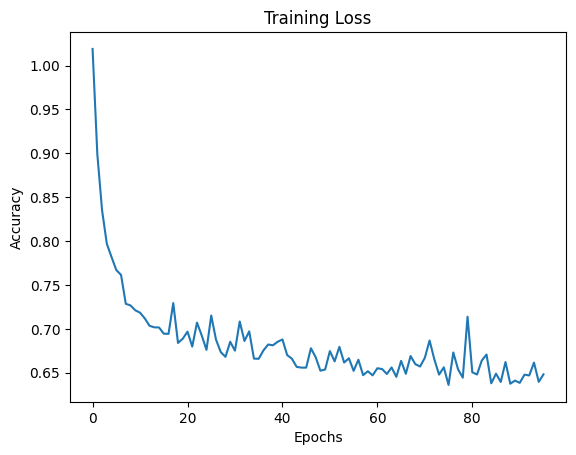

In [14]:
plt.plot(fittedModel.history['val_loss'])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")